### Optimisation of positioning of the turbine
This notebook will look to optimise the positioning of the turbine to provide maximum power output allowing for variation in position (and eventually RPM, and other design parameters)

In [1]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from breastshot_calcs import breastTurbine
from river_class import river_obj
from undershot_calcs import underTurbine


Optimization terminated successfully.
         Current function value: -587.910508
         Iterations: 112
         Function evaluations: 210


(-2.0, 2.0)

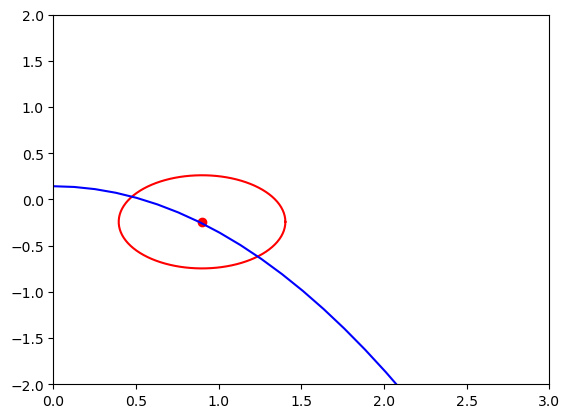

In [2]:
# define a generic river object
river = river_obj(0.7, 0.3, 1.5)

# define the turbine
radius = 0.504
width = 1.008
num_blades = 6
# x_centre = 0
# y_centre = 0

turbine = breastTurbine(radius,width, num_blades, 0, 0, river)

# first define the function to be optimised
def fun(Y):
    # unpack the variables
    x, y = Y
    # define the power
    power = turbine.analysis(x, y , RPM = 15)
    
    return -power

# define the bounds of the optimisation
bounds = [(-1,-1), (4,4)]

# define the initial guess
x0 = [1, -0.2]

# run the optimisation
res = opt.fmin(fun, x0 )
# newx, newy = res.allvecs[-1]

# print the results
newx, newy = res

# reinstantiate the turbine
turbine = breastTurbine(radius, width, num_blades, newx, newy, river)



# plot the results - the turbine is in red
plt.plot(turbine.x_centre, turbine.y_centre, 'ro')
plt.plot(turbine.x, turbine.y, 'r')

# plot the river
plt.plot(river.x_nappe,river.y_nappe, 'b')

plt.xlim(0,3)
plt.ylim(-2,2)









  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -4137.924094658776
        x: [-1.000e-01]
      nit: 0
      jac: [ 0.000e+00]
     nfev: 2
     njev: 1
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


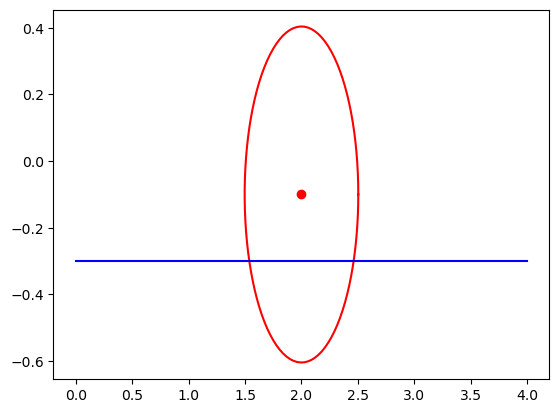

In [23]:
# define a generic river object
river = river_obj(0.7, 0.3, 3)

# define the turbine
radius = 0.504
width = 1.008
num_blades = 6
# x_centre = 0
# y_centre = 0

under_turbine = underTurbine(radius,width, num_blades, 0.3, river)

# first define the function to be optimised
def fun(y):
    # define the power
    power = under_turbine.analysis(y , RPM = 15)
    
    return -power

# max depth
max_depth = -river.depth + radius

# run the optimisation
res = opt.minimize(fun, -0.1, bounds = [(-1, 3)])

print(res)

# newx, newy = res.allvecs[-1]

# reinstantiate the turbine
under_turbine = underTurbine(radius, width, num_blades, res.x, river)

# plot the results - the turbine is in red
plt.plot(under_turbine.x_centre, under_turbine.y_centre, 'ro')
plt.plot(under_turbine.x, under_turbine.y, 'r')

# plot the river as line at -river.depth
plt.plot([-0,4], [-river.depth, -river.depth], 'b')




